In [1]:
import os
import re
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# from scipy.stats import spearmanr, pearsonr
import seaborn as sns
import ipywidgets as widgets
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
# from tqdm.notebook import tqdm
from itables import show
# from statsmodels.formula.api import mixedlm
# from statsmodels.stats.multitest import multipletests
# from statsmodels.tools.sm_exceptions import ConvergenceWarning
from IPython.display import clear_output

## Initialization

### Read metadata, read metabolite table, read family level microbiome feature table

In [2]:
meta = pd.read_csv("input_folder/metadata48.tsv", sep="\t", index_col=0)
crit1 = meta["Group"] != "S"
crit2 = meta["Hour"] != 0

meta = meta.loc[crit1 & crit2, :]
meta["Hour"] = meta["Hour"].astype(int)
meta["GH"] = meta["Group"] + meta["Hour"].astype(str)

meta.index = [re.sub("H$", "", i) for i in meta.index]
show(meta)

In [3]:
def read_met_table(met_table_path):
    met_table = pd.read_csv(met_table_path, sep="\t", index_col=0)
    met_table.set_index("Compound", inplace=True)
    met_table = met_table.loc[:, [c for c in met_table.columns if "-" in c]]
    met_table = met_table.T
    met_table.index = [re.sub("H$", "", i) for i in met_table.index]
    return met_table

met_table_path = "input_folder/MT.tsv"

met_table = read_met_table(met_table_path)
show(met_table)

In [4]:
def read_taxa_table(level, meta=None, n_taxa=12):
    df = pd.read_csv(f"input_folder/feature_tables/feature_table_l{level}.tsv", skiprows=1, sep="\t", index_col=0)
    
    upper_bound = df.sum().to_list()[0]
    # df = df.loc[[idx for idx in df.index.tolist() if "p__" in idx], :]
    df.index = [re.sub(".*p__", "p__", i) for i in df.index.tolist()]
    if level == 2:
        df.index = [re.sub(".*p__", "", i) for i in df.index.tolist()]
    else:
        df.index = [re.sub(";c__.*;", ";", i) for i in df.index.tolist()]
    
    df.columns = [re.sub("H$", "", c) for c in df.columns]
    
    if meta is not None:
        sample_list = meta.index.tolist()
        sample_list = [s for s in sample_list if s[1] != "4"]
        # print(sample_list)
        # print(df.columns.tolist())
        df = df.loc[:, sample_list]
    
    # df = df.loc[:, sample_list]
    df = df.loc[df.sum(axis="columns").sort_values(ascending=False).index.tolist()[:n_taxa], :]
    
    df = df/upper_bound*100
    return df

# l2 = read_taxa_table(2, meta)
# l5 = read_taxa_table(5, meta)
# l5.head()

ft5 = read_taxa_table(5, meta=meta)
upper_bound = ft5.sum().to_list()[0]

ft5.index = [re.sub(".*p__", "p__", i) for i in ft5.index.tolist()]

ft5 = ft5.loc[ft5.sum(axis="columns").sort_values(ascending=False).index.tolist(), :]
ft5 = ft5/upper_bound*100
ft5.columns = [re.sub("H$", "", i) for i in ft5.columns.tolist()]
show(ft5)

In [5]:
ft5 = pd.read_csv("input_folder/feature_tables/feature_table_l5.tsv", skiprows=1, sep="\t", index_col=0)
upper_bound = ft5.sum().to_list()[0]

ft5.index = [re.sub(".*p__", "p__", i) for i in ft5.index.tolist()]

ft5 = ft5.loc[ft5.sum(axis="columns").sort_values(ascending=False).index.tolist(), :]
ft5 = ft5/upper_bound*100
ft5.columns = [re.sub("H$", "", i) for i in ft5.columns.tolist()]
show(ft5)

# Plot taxa composition

In [6]:
taxa_level_descs = {
    2: "Phyla",
    3: "Class",
    4: "Order",
    5: "Family",
    6: "Genera",
}

batches = ["C1", "C2", "C3", "M1", "M2", "M3"]

colors_list = ["#FF5733", "#33FF57", "#3357FF", "#FF33A8", "#A833FF", "#FFD700", "#808080", "#00FFFF", "#B22222", "#FF9900", "#009E11", "#6600CC"]

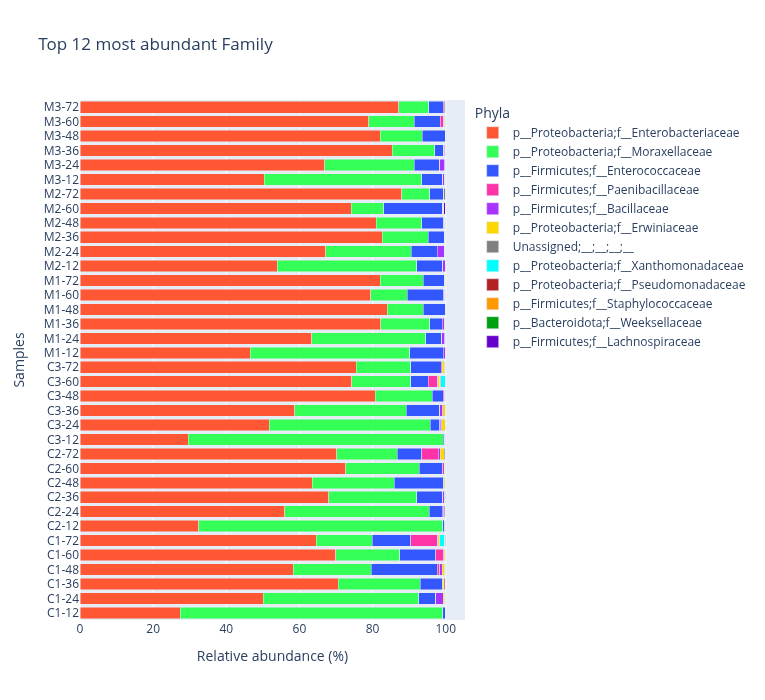

In [7]:
level = 5
df = read_taxa_table(level, meta)

# Transpose and reset index to get a long-form DataFrame
df_long = df.T.reset_index().melt(id_vars='index', var_name='Taxa', value_name='Abundance')
df_long.rename(columns={'index': 'Sample'}, inplace=True)

# Plot using Plotly Express
fig = px.bar(
    df_long,
    x='Abundance',
    y='Sample',
    color='Taxa',
    orientation='h',
    title=f"Top 12 most abundant {taxa_level_descs[level]}",
    color_discrete_sequence=colors_list
)

fig.update_layout(
    barmode='stack',
    xaxis_title='Relative abundance (%)',
    yaxis_title='Samples',
    legend_title='Phyla',
    height=700
)

fig.show()

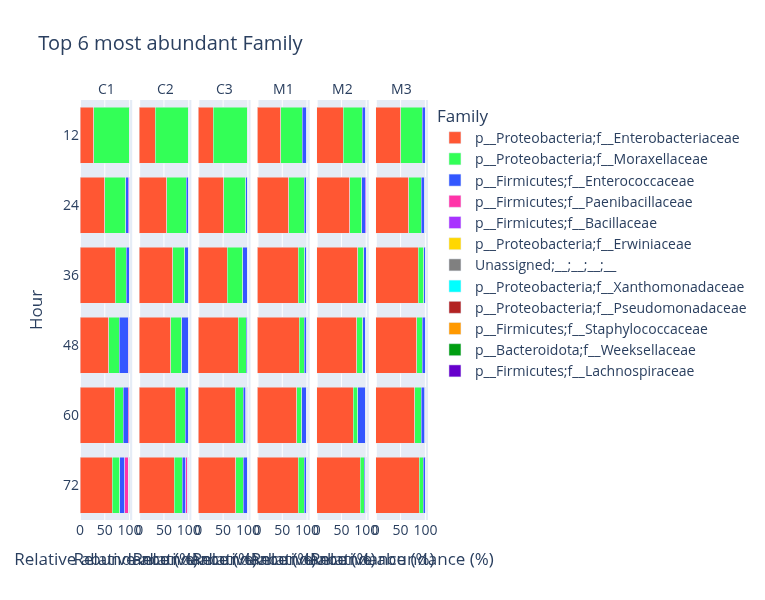

In [8]:
taxa_level = 5
n_taxa = 12

taxa_level_desc = taxa_level_descs[taxa_level]
df = read_taxa_table(taxa_level, meta, n_taxa=n_taxa)

# Prepare long-form DataFrame
long_df_list = []

for batch in batches:
    crit1 = meta["Replicate"] == batch
    sample_list = meta.loc[crit1].index.tolist()

    # Optionally reverse sample order for consistent look
    sample_list = list(reversed(sample_list))
    
    # Subset and melt
    temp_df = df[sample_list].T
    temp_df["Sample"] = temp_df.index
    temp_df["Batch"] = batch
    long_df = temp_df.melt(id_vars=["Sample", "Batch"], var_name="Taxa", value_name="Abundance")

    # Simplify sample names if needed
    long_df["Sample"] = long_df["Sample"].apply(lambda x: re.sub(".*-", "", x))

    long_df_list.append(long_df)

# Combine all batches into one DataFrame
final_df = pd.concat(long_df_list)

# Plot
fig = px.bar(
    final_df,
    x="Abundance",
    y="Sample",
    color="Taxa",
    facet_col="Batch",
    orientation="h",
    title=f"Top 6 most abundant {taxa_level_desc}",
    color_discrete_sequence=colors_list,
    category_orders={"Batch": batches}  # Optional: keep batch order consistent
)
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
fig.update_layout(
    font=dict(size=14),  # Increase overall font size
    barmode="stack",
    yaxis_title="Hour",
    legend_title_text=taxa_level_desc,
    height=600,
    margin=dict(b=80)  # Extra bottom space for legend if needed
)

for axis in fig.layout:
    if axis.startswith("xaxis"):
        fig.layout[axis].title.text = "Relative abundance (%)"
        
fig.show()

#### It is quite interesting how we have Paenibacillae later in fermentation only in conventional group
#### Also, if we ignore the top five, we can start seing that we have a lot more Erwiniaceae in conventional, missing in modified

# Plot beta diversity

In [9]:
beta_divs = [i for i in os.listdir("input_folder/coords/") if i.endswith("coords.tsv")]
beta_divs = [re.sub("_coor.*", "", i) for i in beta_divs]
beta_divs

['jaccard', 'bray_curtis', 'weighted_unifrac', 'unweighted_unifrac']

In [10]:
def read_raw_ord_table(beta):
    with open(f"input_folder/coords/{beta}_coords.tsv") as f:
        s = f.readlines()
    
    for idx, l in enumerate(s):
        if l.startswith("Site"):
            n1 = idx + 1
            break
    
    for idx, l in enumerate(s):
        if l.startswith("Biplot"):
            n2 = idx -1
            break
    
    s = s[n1:n2]
    s = [l.strip() for l in s]
    s = [l.split("\t") for l in s]
    
    s = pd.DataFrame(s)
    s.set_index(0, inplace=True)
    s = s.loc[:, :3]

    
    s.columns = [f"PCoA{c}" for c in s.columns.tolist()]

    for i in range(1,3):
        s[f"PCoA{i}"] = pd.to_numeric(s[f"PCoA{i}"])
    
    s.index = [re.sub("H$", "", i) for i in s.index]
    l2 = read_taxa_table(2, meta=meta)
    l5 = read_taxa_table(5, meta=meta)
    # print(l2.index.tolist())
    # print(s.index.tolist())
    s = meta.merge(s, left_index=True, right_index=True)
    s = s.merge(l2.T, left_index=True, right_index=True)
    s = s.merge(l5.T, left_index=True, right_index=True)
    return s

beta = beta_divs[0]
t = read_raw_ord_table(beta)
show(t)

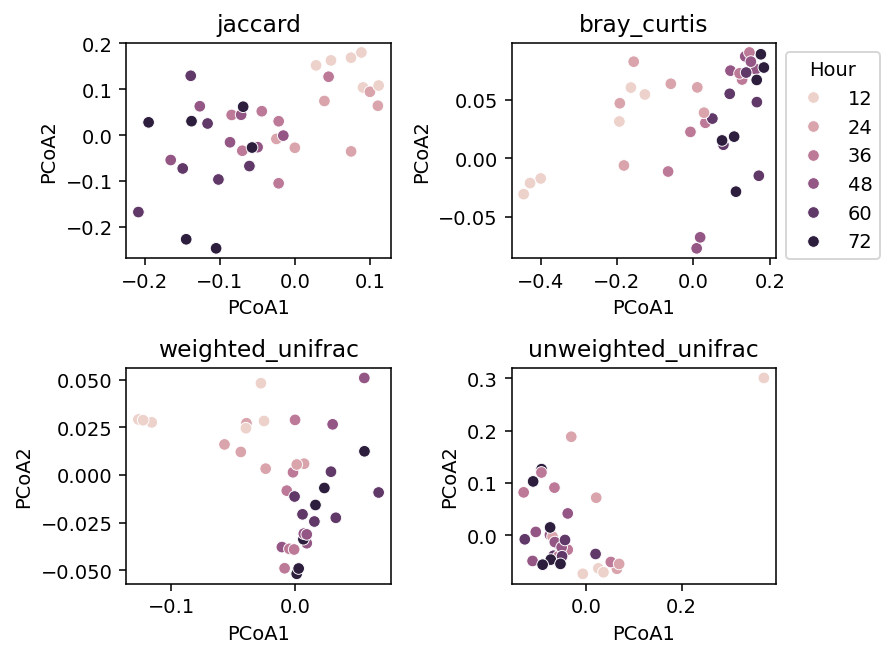

In [11]:
hue="Hour"
fig, axs = plt.subplots(ncols=2, nrows=2, dpi = 140)
axs = axs.ravel()

for idx, beta in enumerate(beta_divs):
    ax = axs[idx]

    if idx != 1:
        sns.scatterplot(read_raw_ord_table(beta), x="PCoA1", y="PCoA2", hue=hue, legend=False, ax=ax)
    else:
        sns.scatterplot(read_raw_ord_table(beta), x="PCoA1", y="PCoA2", hue=hue, ax=ax)
        ax.legend(bbox_to_anchor=(1,1), title=hue)
    ax.set_title(beta)

    
plt.tight_layout()
plt.show()

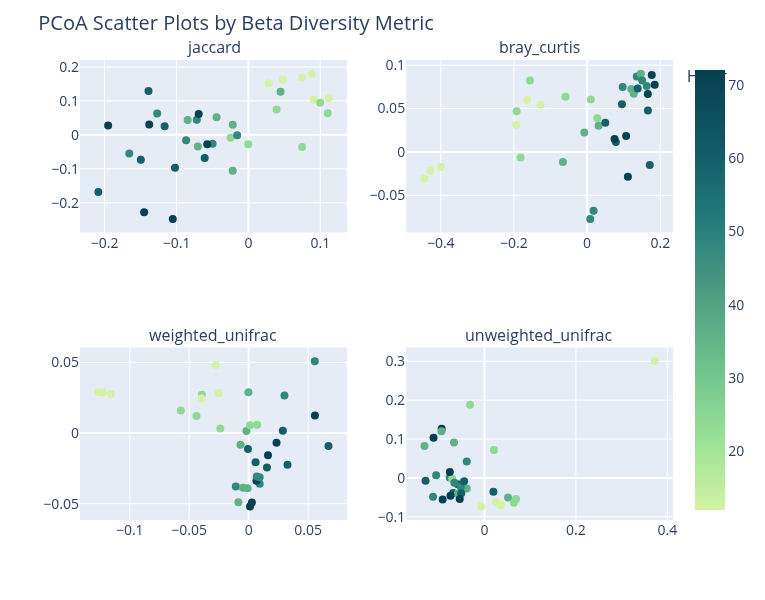

In [12]:
# Setup
hue = "Hour"
n_cols = 2
n_rows = 2
fig = make_subplots(rows=n_rows, cols=n_cols, subplot_titles=beta_divs)

# Flatten subplot indexing
plot_idx = 0
for row in range(1, n_rows + 1):
    for col in range(1, n_cols + 1):
        if plot_idx >= len(beta_divs):
            break
        beta = beta_divs[plot_idx]
        df_beta = read_raw_ord_table(beta)

        # Create a scatter plot
        scatter_fig = px.scatter(
            df_beta,
            x="PCoA1",
            y="PCoA2",
            color=hue,
            color_continuous_scale="aggrnyl"  # ← Change here
        )

        # Add traces manually to subplot
        for trace in scatter_fig.data:
            # Only show legend on the second subplot (like your original code)
            showlegend = (plot_idx == 1)
            trace.marker.size = 8
            trace.showlegend = showlegend
            fig.add_trace(trace, row=row, col=col)

        plot_idx += 1

# Update layout
fig.update_layout(
    coloraxis=dict(colorscale='Emrld'),
    height=600,
    width=800,
    title_text="PCoA Scatter Plots by Beta Diversity Metric",
    legend_title=hue,
    margin=dict(t=60),
    font=dict(size=14)
)

fig.show()

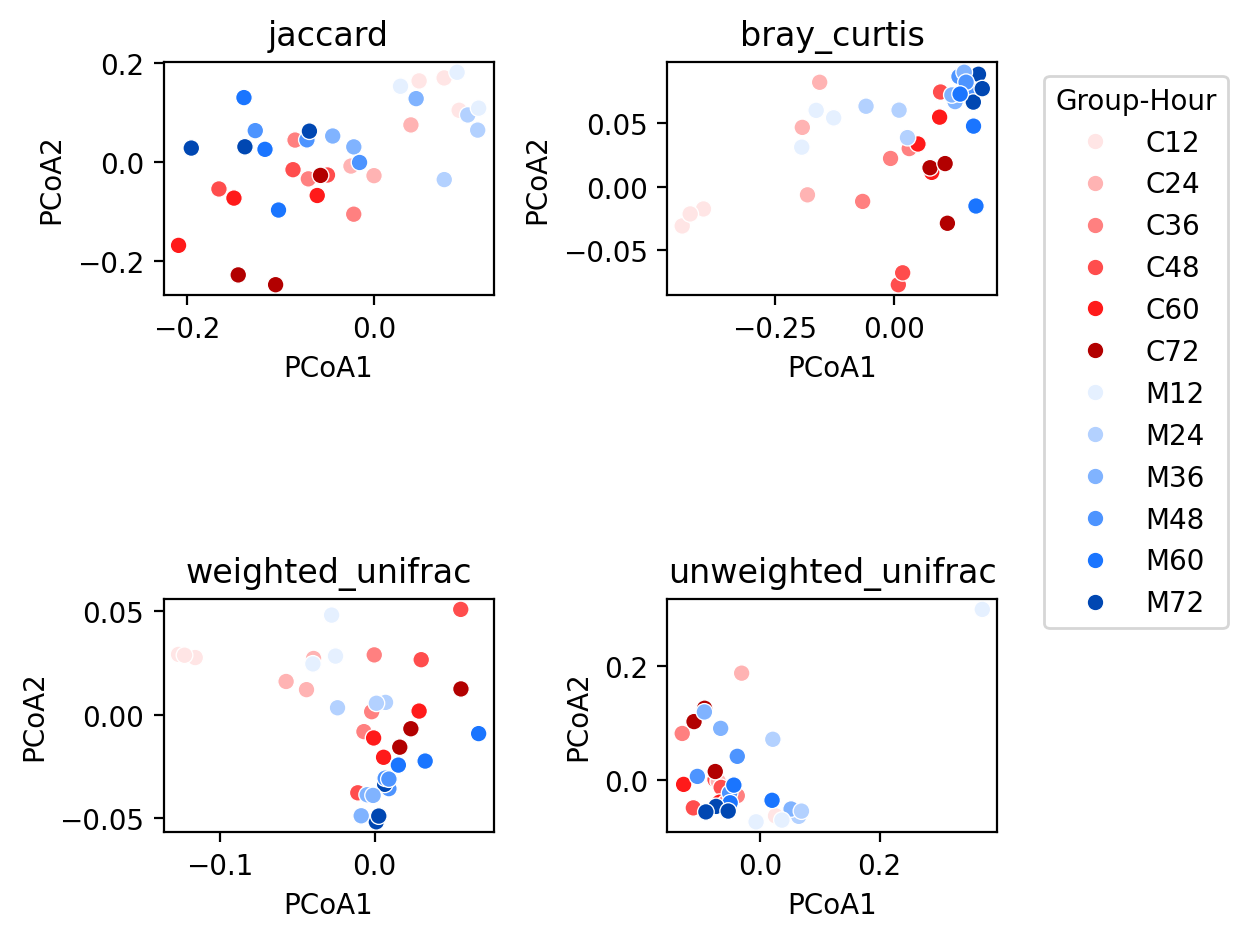

In [13]:
palette_gh = {   # Sample_Source
    'C12': "#FFE5E5", 'C24': "#FFB3B3", 'C36': "#FF8080",
    'C48': "#FF4D4D", 'C60': "#FF1A1A", 'C72': "#B20000",
    'M12': "#E5F0FF", 'M24': "#B3D1FF", 'M36': "#80B3FF",
    'M48': "#4D94FF", 'M60': "#1A75FF", 'M72': "#0047B2"
}

hue = "GH"
title = "Group-Hour"
fig, axs = plt.subplots(ncols=2, nrows=2, dpi = 200)
axs = axs.ravel()

for idx, beta in enumerate(beta_divs):
    ax = axs[idx]

    if idx != 1:
        sns.scatterplot(read_raw_ord_table(beta), x="PCoA1", y="PCoA2", hue=hue,
                        palette=palette_gh, legend=False, ax=ax)
    else:
        sns.scatterplot(read_raw_ord_table(beta), x="PCoA1", y="PCoA2", hue=hue,
                        palette=palette_gh, ax=ax)
        ax.legend(bbox_to_anchor=(1.1,1), title=title)
        # ax.legend.title = "Group"
    ax.set_title(beta)

    
plt.tight_layout()
plt.show()

In [ ]:
hue = "GH"
title = "Group-Hour"

# Convert seaborn color palette to plotly-friendly format
# Plotly needs a color_discrete_map, mapping category -> hex
color_map = palette_gh

n_cols = 2
n_rows = 2
fig = make_subplots(rows=n_rows, cols=n_cols, subplot_titles=beta_divs)

plot_idx = 0
for row in range(1, n_rows + 1):
    for col in range(1, n_cols + 1):
        if plot_idx >= len(beta_divs):
            break

        beta = beta_divs[plot_idx]
        df_beta = read_raw_ord_table(beta)

        # Create a Plotly Express scatter plot with color mapping
        scatter_fig = px.scatter(
            df_beta,
            x="PCoA1",
            y="PCoA2",
            color=hue,
            color_discrete_map=color_map,
        )

        # Add traces to subplot
        for trace in scatter_fig.data:
            trace.showlegend = (plot_idx == 1)  # Only show legend on second subplot
            trace.marker.size = 10              # Make dots bigger
            fig.add_trace(trace, row=row, col=col)

        plot_idx += 1

# Final layout tweaks
fig.update_layout(
    height=700,
    width=900,
    title_text="PCoA Scatter Plots by Beta Diversity Metric",
    legend_title_text=title,
    font=dict(size=14),
    margin=dict(t=60)
)

# Optional: clean subplot titles (if needed)
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))

fig.show()

# Correlate microbiome-metabolome

### Mixed linear effects model
- Account for random effects within group_hour
- Assess fixed effects of hour, group, group_hour and their interaction on metabolite concentration

### Atempting mixed linear effect model, modeling how Concentration changes with Group, Hour, and their interaction, while accounting for random effects within Group-Hour samples 

In [ ]:
adjusted_df = pd.read_csv("input_folder/lme_metabolite_corr.tsv", sep="\t", index_col=0)
show(adjusted_df)

In [ ]:
# Sorting widgets
sort_radio = widgets.RadioButtons(
    options=["Metabolite", "p_Group_adj", "p_Hour_adj", "p_Interaction_adj"],
    description="Sort metabolites by:",
    layout={'width': '300px'}
)

asc_toggle = widgets.ToggleButton(
    value=True,
    description='Ascending',
    tooltip='Toggle ascending/descending sort',
    icon='sort-amount-up'
)


metabolite_dropdown = widgets.Dropdown(
    description='Metabolite:',
    layout=widgets.Layout(width='50%')
)

output = widgets.Output()

# Update dropdown options based on sorting widget state
def get_sorted_metabolites(sort_col, ascending):
    col = sort_col if sort_col in adjusted_df.columns else "Metabolite"
    sorted_df = adjusted_df.sort_values(col, ascending=ascending)
    return sorted_df["Metabolite"].tolist()

def plot_metabolite_bar(change, stat_col):
    metabolite = change["new"]
    replicates = meta.loc[:, "Replicate"].unique().tolist()
    
    metabolite_max = met_table.loc[:, metabolite].max()
    
    fig, axs = plt.subplots(ncols=len(replicates), figsize=(12, 4))
    
    if len(replicates) == 1:
        axs = [axs]
    
    for idx, replicate in enumerate(replicates):
        ax = axs[idx]
        sub_meta = meta.loc[meta["Replicate"] == replicate, :]
        sub_meta = sub_meta.sort_values("Hour")
        sub_met_table = met_table.loc[sub_meta.index.tolist(), [metabolite]]
        
        sns.barplot(data=sub_met_table, y=sub_met_table.index, x=metabolite, ax=ax)
        ax.set_xlabel(replicate)
        
        if metabolite_max > 0:
            ax.set_xlim(0, metabolite_max)
        
        if idx == 0:
            ax.set_ylabel(metabolite)

            newticklabels = [re.sub("C.-", "", yticklabel.get_text()) for yticklabel in ax.get_yticklabels()]
            newticklabels = [re.sub("$", "H", yticklabel) for yticklabel in newticklabels]
            ax.set_yticks(ax.get_yticks())
            ax.set_yticklabels(newticklabels)
        else:
            ax.set_ylabel(None)
            ax.set_yticklabels([])
    
    # Get stat value if exists
    stat_val = None
    if stat_col in adjusted_df.columns:
        try:
            stat_val = adjusted_df.loc[adjusted_df["Metabolite"] == metabolite, stat_col].values[0]
        except IndexError:
            stat_val = None
    
    title_str = metabolite
    if stat_col != "Metabolite":
        title_str += f" ({stat_col} = {stat_val})"
    
    fig.suptitle(title_str)
    plt.tight_layout()
    plt.show()
    plt.close(fig)


# Flag to ignore dropdown change when updating options programmatically
ignore_dropdown_change = False

def update_dropdown_options(*args):
    global ignore_dropdown_change
    metabolites = get_sorted_metabolites(sort_radio.value, asc_toggle.value)
    ignore_dropdown_change = True
    metabolite_dropdown.options = metabolites
    if metabolites:
        metabolite_dropdown.value = metabolites[0]  # Reset to first after sorting change
    ignore_dropdown_change = False

def on_dropdown_change(change):
    if ignore_dropdown_change:
        print(f"Ignored dropdown change: {change['new']}")
        return  # Ignore changes triggered programmatically
    
    if change["type"] == "change" and change["name"] == "value":
        # print(f"Dropdown changed to: {change['new']}")
        with output:
            clear_output(wait=True)
            plot_metabolite_bar(change, sort_radio.value)

# Connect widget observers
sort_radio.observe(lambda change: update_dropdown_options(), names='value')
asc_toggle.observe(lambda change: update_dropdown_options(), names='value')
metabolite_dropdown.observe(on_dropdown_change, names='value')

# Initial update to set options correctly
update_dropdown_options()

# Layout and display
controls = widgets.HBox([sort_radio, asc_toggle])
dashboard = widgets.VBox([controls, metabolite_dropdown, output])

display(dashboard)

# Use ignore flag around initial plot to avoid triggering duplicate plot on dropdown observer
ignore_dropdown_change = True
with output:
    clear_output(wait=True)
    plot_metabolite_bar({'new': metabolite_dropdown.value}, sort_radio.value)
ignore_dropdown_change = False

### Correlate metabolome with Paenibacillaceae

In [ ]:
ft5 = read_taxa_table(5, meta=meta)
# Prepare your taxa vector
paeni = ft5.loc['p__Firmicutes;f__Paenibacillaceae', :].T
paeni = paeni.rename("Paenibacillaceae")

## Significant metabolite, sorted by p_Pearson_adj

In [ ]:
sig_corrs = pd.read_csv("input_folder/paeni_corr.tsv", sep="\t", index_col=0)
show(sig_corrs.sort_values("p_Pearson_adj", ascending=False))

### Scatterplot of metabolite against Paenibacillae

In [ ]:
# Paeni series
paeni.name = "Paenibacillaceae"

# Dropdowns
metabolite_dropdown = widgets.Dropdown(
    description='Metabolite:',
    layout=widgets.Layout(width='50%')
)

metadata_dropdown = widgets.Dropdown(
    options=["Group", "Hour", "GH"],
    description='Metadata:',
    layout=widgets.Layout(width='50%')
)

# Sorting controls
sort_by_radio = widgets.RadioButtons(
    options=['Metabolite', 'r_Pearson', 'p_Pearson', 'r_Spearman', 'p_Spearman', 'p_Pearson_adj', 'p_Spearman_adj'],
    value='p_Pearson_adj',
    description='Sort metabolites by:'
)

order_toggle = widgets.ToggleButtons(
    options=[('Descending', False), ('Ascending', True)],
    value=False,
    description='Order metabolites:'
)

# Output widget
out = widgets.Output()

# Function to update the dropdown based on sort controls
def update_metabolite_dropdown(*args):
    sort_col = sort_by_radio.value
    ascending = order_toggle.value

    sorted_mets = sig_corrs.sort_values(sort_col, ascending=ascending)["Metabolite"].tolist()
    metabolite_dropdown.options = sorted_mets

    # Reset value to the first option to trigger update
    metabolite_dropdown.value = sorted_mets[0] if sorted_mets else None

# Attach to both sorting widgets
sort_by_radio.observe(update_metabolite_dropdown, names='value')
order_toggle.observe(update_metabolite_dropdown, names='value')

# Plotting function
def plot_corr(change=None):
    metabolite_name = metabolite_dropdown.value
    metadata_name = metadata_dropdown.value

    if metabolite_name is None or metadata_name is None:
        return

    smet = met_table[metabolite_name]
    corr_df = pd.merge(paeni, smet, left_index=True, right_index=True)
    corr_df.columns = ["Paenibacillaceae", "Metabolite"]
    corr_df = pd.merge(corr_df, meta, left_index=True, right_index=True)

    # Plot in Output widget
    with out:
        clear_output(wait=True)
        g = sns.lmplot(
            data=corr_df,
            x="Paenibacillaceae",
            y="Metabolite",
            hue=metadata_name,
            scatter_kws={"s": 40, "alpha": 0.8},
            height=4,
            aspect=1.5,
            ci=0,
            facet_kws={"legend_out": True}
        )
        g.fig.subplots_adjust(right=0.85)

        # Get p_Pearson_adj for title
        p_val = sig_corrs.set_index("Metabolite").loc[metabolite_name, "p_Pearson_adj"]
        g.fig.suptitle(f"{metabolite_name}, p_Pearson_adj={p_val:.2e}")

        plt.close(g.fig)
        display(g.fig)

# Attach observers to dropdowns
metabolite_dropdown.observe(plot_corr, names='value')
metadata_dropdown.observe(plot_corr, names='value')

# Layout widgets
control_row = widgets.HBox([metabolite_dropdown, sort_by_radio, order_toggle])
control_row = widgets.VBox([control_row, metadata_dropdown])
display(widgets.VBox([control_row, out]))

# Initial dropdown population and first plot
update_metabolite_dropdown()